In [7]:
import os
import keras
import numpy as np
import pandas as pd

In [2]:
def find_feature_extraction_files(directory, use_augmented=True):
    """
    Searches for 'feature_extraction.csv' files within each subdirectory of a given directory.
    Optionally excludes subdirectories containing '_augmented' in their names.

    Args:
    directory (str): The path to the directory to search within.
    use_augmented (bool): If False, excludes subdirectories with '_augmented' in their names.

    Returns:
    list: A list of full paths to each 'feature_extraction.csv' file found.
    """
    csv_files = []
    # Walk through each subdirectory in the provided directory
    for root, dirs, files in os.walk(directory):
        # Skip directories that contain '_augmented' in their names if use_augmented is False
        if not use_augmented and '_augmented' in root:
            continue
        
        # Check if 'feature_extraction.csv' is in the files list
        if 'feature_extraction.csv' in files:
            # Construct full path and add to the list
            full_path = os.path.join(root, 'feature_extraction.csv')
            csv_files.append(full_path)
            
    return csv_files


In [3]:
def read_csv(data_file_path):
    """
    Reads a CSV file and extracts the feature data and labels.

    Args:
    data_file_path (str): The path to the CSV file.

    Returns:
    tuple: A tuple containing:
        - X_data (np.ndarray): The feature data as a NumPy array.
        - y_data (np.ndarray): The labels as a NumPy array, rounded to 0 decimal places.
    """
    # Read the CSV file into a DataFrame
    df_read_file = pd.read_csv(data_file_path)
    
    # Extract features (all columns up to 'Label')
    df_Acc = df_read_file.loc[:, :"Label"]
    X_data = df_Acc.to_numpy()
    
    # Extract labels and round them
    y_data = df_read_file.loc[:, "Label"]
    y_data = np.around(y_data, decimals=0)

    return X_data, y_data

def normalize_positions(data, screen_width=1920, screen_height=1080):
    """
    Normalizes position data (PosX and PosY) by dividing by the screen resolution dimensions.

    Args:
    data (np.ndarray): The input data containing position information.
    screen_width (int, optional): The width of the screen for normalization. Default is 1920.
    screen_height (int, optional): The height of the screen for normalization. Default is 1080.

    Returns:
    np.ndarray: The normalized data.
    """
    # Indices for PosX and PosY columns
    posX_columns = [0] + list(range(4, 22))   # PosX: Columns 0 and 4 to 21
    posY_columns = [1] + list(range(22, 39))  # PosY: Columns 1 and 22 to 38
    
    # Normalize PosX columns by dividing by the screen width
    data[:, posX_columns] = data[:, posX_columns] / screen_width
    
    # Normalize PosY columns by dividing by the screen height
    data[:, posY_columns] = data[:, posY_columns] / screen_height
    
    return data


def handle_indices(data, indexes_of_labels, label_value=0, label_col=0):
    """
    Identifies and returns specific indices based on provided label indices and certain conditions.

    Args:
    data (np.ndarray): The array containing label data.
    indexes_of_labels (list): List of indices where specific labels are found.
    label_value (int, optional): The label value to check for around specific indices. Default is 0.
    label_col (int, optional): The column index of the label data in the array. Default is 0.

    Returns:
    list: Sorted list of indices based on the specified conditions.
    """
    # Extract the column data if data has more than one column
    data = data[:, label_col] if data.ndim > 1 else data
    
    # Initialize a set to store unique found indexes
    found_indexes = set(indexes_of_labels)

    if indexes_of_labels:
        # Check for label_value exactly 3 lines before the first label index
        first_label_index = indexes_of_labels[0]
        target_index_before_first = first_label_index - 3
        if 0 <= target_index_before_first < len(data) and data[target_index_before_first] == label_value:
            found_indexes.add(target_index_before_first)

        # Check for label_value exactly 3 lines after the last label index
        last_label_index = indexes_of_labels[-1]
        target_index_after_last = last_label_index + 3
        if 0 <= target_index_after_last < len(data) and data[target_index_after_last] == label_value:
            found_indexes.add(target_index_after_last)

        # Check for label_value in the middle between given label indices
        for i in range(len(indexes_of_labels) - 1):
            start_index = indexes_of_labels[i]
            end_index = indexes_of_labels[i + 1]
            middle_index = (start_index + end_index) // 2
            if data[middle_index] == label_value:
                found_indexes.add(middle_index)

    # Convert set to a sorted list
    sorted_indexes = sorted(found_indexes)
    
    return sorted_indexes


def lstm_data_transform(x_data, keys, num_steps=6):
    """
    Transforms data for LSTM model training by creating sequences of a specified length.

    Args:
    x_data (np.ndarray): The feature data array.
    y_data (np.ndarray): The target labels array.
    keys (list): The indices marking the end of each sequence.
    num_steps (int, optional): The number of time steps in each sequence. Default is 6.

    Returns:
    tuple: A tuple containing:
        - x_array (np.ndarray): The array of feature sequences.
        - y_array (np.ndarray): The array of corresponding target labels.
    """
    X, y = list(), list()
    
    # Loop over the provided end indices
    for end_ix in keys:
        # Calculate the start index for the current window
        start_ix = end_ix - num_steps + 1
        
        # Ensure the start index is not negative
        if start_ix < 0:
            continue
        
        # Get a sequence of data for x
        seq_X = x_data[start_ix:end_ix + 1, :-1]
        
        # Check if the sequence has the correct number of steps
        if seq_X.shape[0] == num_steps:
            # Append the sequence and target to the lists
            X.append(seq_X)
    
    # Convert the lists to numpy arrays
    x_array = np.array(X)
    y_array = np.array([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0])  # the label order of a series of sequences is fixed, therefore the hard-coded y_array
    
    return x_array, y_array

In [9]:
def extract_relevant_rows(csv_path):
    """
    Extracts and processes relevant rows from a CSV file, normalizing position data,
    finding specific indices based on label values, and transforming the data for LSTM input.

    Args:
    csv_path (str): The path to the CSV file.

    Returns:
    tuple: A tuple containing:
        - x_data (np.ndarray): The array of feature sequences for LSTM.
        - y_data (np.ndarray): The array of corresponding target labels for LSTM.
    """
    # Read the CSV file and extract feature data (x_array) and labels (y_array)
    x_array, y_array = read_csv(csv_path)
    
    # Normalize the position columns in the feature data
    x_array = normalize_positions(x_array)

    # Define the values to check in the labels
    values_to_check = {1, 2, 3, 4, 5}

    # Find the indices of values in y_array that are in values_to_check
    indexes_of_labels = [index for index, value in enumerate(y_array) if value in values_to_check]

    # Handle and sort the indices based on specific conditions
    sorted_indices = handle_indices(y_array, indexes_of_labels)
    
    # Uncomment the line below to print sorted indices for debugging
    # print('Sorted indices: ', sorted_indices)
    
    # If the number of sorted indices is 10 or less, print the CSV path
    if len(sorted_indices) <= 10:
        print(csv_path)

    # Transform the data for LSTM input based on sorted indices
    x_data, y_data = lstm_data_transform(x_array, sorted_indices, num_steps=6)

    return x_data, y_data


In [47]:
# Specify the directory containing the files
directory = 'Frames'

use_augmented = True

# Find all 'feature_extraction.csv' files in the directory
file_paths = find_feature_extraction_files(directory, use_augmented=use_augmented)

# Print the number of files found
print(f"Number of files found: {len(file_paths)}")


Number of files found: 1735


In [48]:
# Define the number of time steps and input signals per time step
num_of_steps = 6
num_of_input_signals = 55

# Initialize empty arrays to hold the accumulated data and labels
X_data = np.empty([0, num_of_steps, num_of_input_signals], dtype="float32")
y_data = np.empty([0], dtype="float32")

# Iterate over each file path found in the previous step
for file_path in file_paths:
    # Extract relevant rows and labels from the current file
    data, labels = extract_relevant_rows(file_path)
    
    # Append the extracted data to the accumulated X_data array
    X_data = np.append(X_data, data[:], axis=0)
    
    # Append the extracted labels to the accumulated y_data array
    y_data = np.append(y_data, labels, axis=0)

# Print the final shapes of the accumulated data and labels
print(X_data.shape)   # Should show (number_of_samples, num_of_steps, num_of_input_signals) if configured correctly
print(y_data.shape)   # Should show (number_of_samples,)

(19085, 6, 55)
(19085,)


In [49]:
# One-hot encode the labels using Keras utility function
# The number of classes is specified as 6, resulting in a one-hot encoded array with 6 columns
final_labels_encoded = keras.utils.to_categorical(y_data, num_classes=6)

# Print the one-hot encoded labels to verify the result
print(final_labels_encoded)
# Print the shape of the one-hot encoded labels array to confirm the dimensions
print('y_data shape:', final_labels_encoded.shape)


[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]]
y_data shape: (19085, 6)


In [50]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
    
for train_index, test_index in sss.split(X_data, y_data): 
    X_train_pre, X_test = X_data[train_index], X_data[test_index] 
    y_train_pre, y_test = final_labels_encoded[train_index], final_labels_encoded[test_index] 
    
for train_index, val_index in sss.split(X_train_pre, y_train_pre):
    X_train, X_val = X_train_pre[train_index], X_train_pre[val_index] 
    y_train, y_val = y_train_pre[train_index], y_train_pre[val_index] 
    
print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("------------------------------------\n")
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)
print("------------------------------------\n")
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)


Train data shape: (15458, 6, 55)
Train labels shape: (15458, 6)
------------------------------------

Test data shape: (1909, 6, 55)
Test labels shape: (1909, 6)
------------------------------------

Validation data shape: (1718, 6, 55)
Validation labels shape: (1718, 6)


In [51]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import LSTM, Dense, InputLayer, BatchNormalization, Bidirectional

# Define the CNN-LSTM model
model = keras.Sequential()

# Input layer - assumes input_shape is defined appropriately for your data
# For example, input_shape could be (sequence_length, features_per_step)
model.add(InputLayer(shape=(6, 55)))
# Batch Normalization layer before LSTM to normalize inputs
model.add(BatchNormalization())

# Adding a Bidirectional LSTM layer with L2 regularization
# Note: Adjust the `l2` regularization strength as needed
model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l1_l2(l1=1e-5, l2=0.001))))
# Adding another Bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, return_sequences=False, dropout=0.3,recurrent_dropout=0.3)))

# Output layer - assuming a classification problem with 6 classes
model.add(Dense(6, activation='softmax'))

In [64]:
# Training parameters based on whether the augmented dataset is used
if use_augmented:
    batch_size = 128
    epochs = 500
    patience_es = 20
    factor_lr = 0.15
    patience_lr = 15
else:
    batch_size = 32
    epochs = 250
    patience_es = 50
    factor_lr = 0.3
    patience_lr = 15

In [55]:
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
# EarlyStopping: Stop training if validation loss does not improve
es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=patience_es, verbose=1, restore_best_weights=True)
# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factor_lr, patience=patience_lr)

In [56]:
# Print the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 6, 55)          │           220 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 6, 200)         │       124,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,026 (1.40 MB)

 Trainable params: 366,916 (1.40 MB)

 Non-trainable params: 110 (440.00 B)

In [57]:
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    callbacks=[es_callback, reduce_lr], 
                    validation_data=(X_val, y_val), 
                    batch_size=batch_size, 
                    verbose=1)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Save the model
model.save('model.keras')

Epoch 1/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5080 - loss: 1.3884 - val_accuracy: 0.5396 - val_loss: 1.8264 - learning_rate: 0.0010
Epoch 2/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6230 - loss: 0.9492 - val_accuracy: 0.5658 - val_loss: 1.0942 - learning_rate: 0.0010
Epoch 3/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6399 - loss: 0.8580 - val_accuracy: 0.6368 - val_loss: 0.8499 - learning_rate: 0.0010
Epoch 4/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6521 - loss: 0.8229 - val_accuracy: 0.6676 - val_loss: 0.7725 - learning_rate: 0.0010
Epoch 5/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6467 - loss: 0.8017 - val_accuracy: 0.6903 - val_loss: 0.7306 - learning_rate: 0.0010
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6601 - loss: 0.7668 - val_accuracy: 0.7020 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6789 - l

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

# Load the best model
model_filepath = 'model.keras'
best_model = keras.models.load_model(model_filepath)

# Predict on the test data
predictions = best_model.predict(X_test)

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


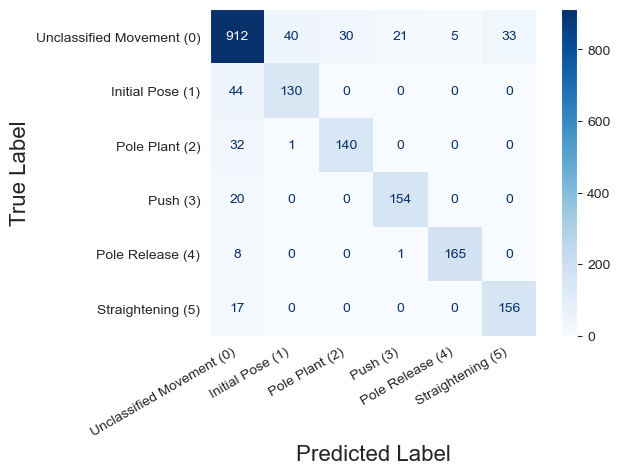

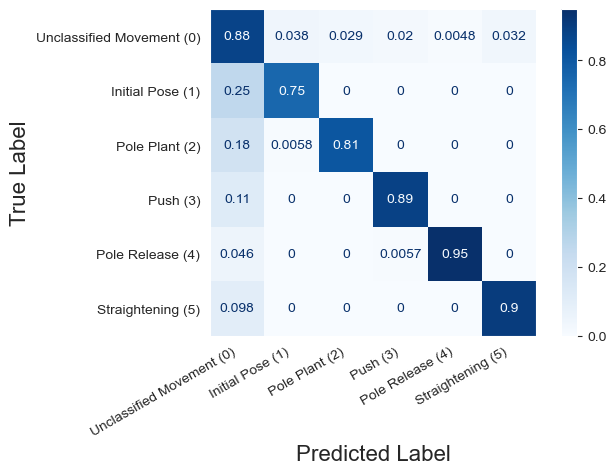

In [66]:
# Define your custom string labels
labels = ['Unclassified Movement (0)', 'Initial Pose (1)', 'Pole Plant (2)', 'Push (3)', 'Pole Release (4)', 'Straightening (5)']

# Function to plot and save confusion matrices
def plot_confusion_matrix(cm, labels, filename, normalize=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.grid(False)  # Turn off grid lines
    plt.xticks(rotation=45)
    plt.gcf().autofmt_xdate()  # Adjust layout for labels
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.savefig(filename, format='eps', bbox_inches='tight')
    plt.show()

# Generate and plot the raw confusion matrix
cm_raw = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm_raw, labels, 'confusion_matrix.eps')

# Generate and plot the normalized confusion matrix
cm_normalized = confusion_matrix(true_classes, predicted_classes, normalize='true')
plot_confusion_matrix(cm_normalized, labels, 'confusion_matrix_normalized.eps')

In [67]:
# Calculate and print precision, recall, and F1-score per class
precision = precision_score(true_classes, predicted_classes, average=None)
recall = recall_score(true_classes, predicted_classes, average=None)
f1 = f1_score(true_classes, predicted_classes, average=None)
print('Precision per class:', precision)
print('Recall per class:', recall)
print('F1-Score per class:', f1)

# Calculate and print average precision, recall, and F1-score
precision_avg = precision_score(true_classes, predicted_classes, average='macro')
recall_avg = recall_score(true_classes, predicted_classes, average='macro')
f1_avg = f1_score(true_classes, predicted_classes, average='macro')
print('Average Precision:', precision_avg)
print('Average Recall:', recall_avg)
print('Average F1-Score:', f1_avg)

# Calculate and print overall accuracy
overall_accuracy = np.trace(cm_raw) / np.sum(cm_raw) * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

Precision per class: [0.88286544 0.76023392 0.82352941 0.875      0.97058824 0.82539683]
Recall per class: [0.87608069 0.74712644 0.80924855 0.88505747 0.94827586 0.9017341 ]
F1-Score per class: [0.87945998 0.75362319 0.81632653 0.88       0.95930233 0.86187845]
Average Precision: 0.8562689718414949
Average Recall: 0.8612538534528552
Average F1-Score: 0.8584317463919514
Overall Accuracy: 86.80%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


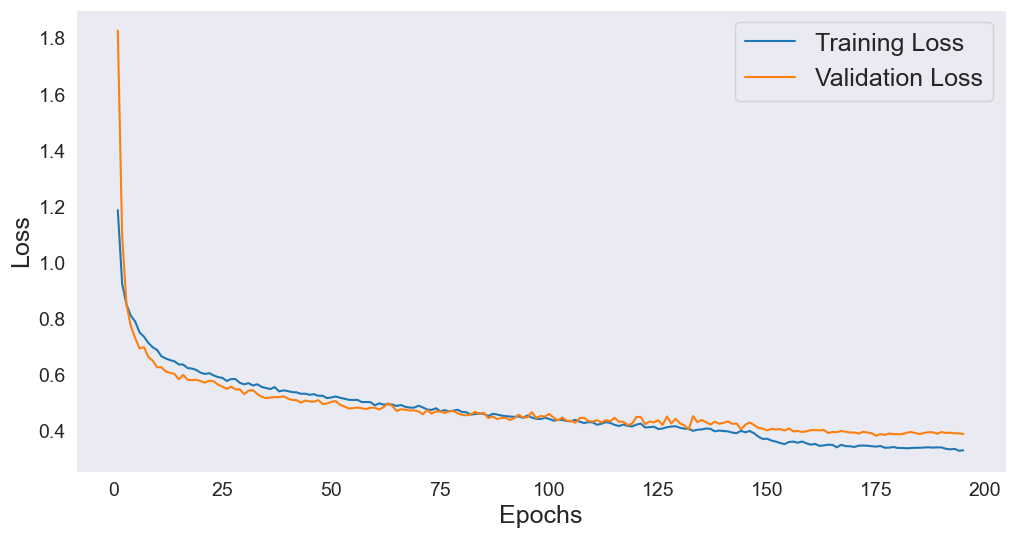

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


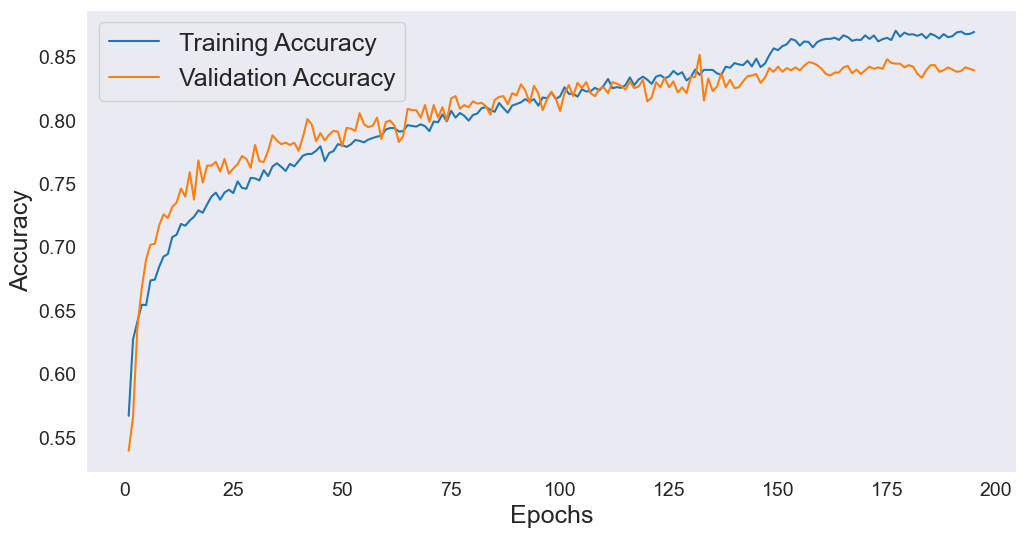

In [68]:
# Extract and plot training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')
val_accuracy = history.history.get('val_accuracy')

epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)  # Turn off the grid
plt.savefig('best_training_loss.eps', format='eps', bbox_inches='tight')
plt.show()

# Plotting training and validation accuracy, if available
if accuracy and val_accuracy:
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.savefig('best_training_accuracy.eps', format='eps', bbox_inches='tight')
    plt.show()

In [69]:
# Save the best model with a dataset-dependent filename
model_filepath = 'Results/xcs_model_augmented.keras' if use_augmented else 'Results/xcs_model.keras'
best_model.save(model_filepath)

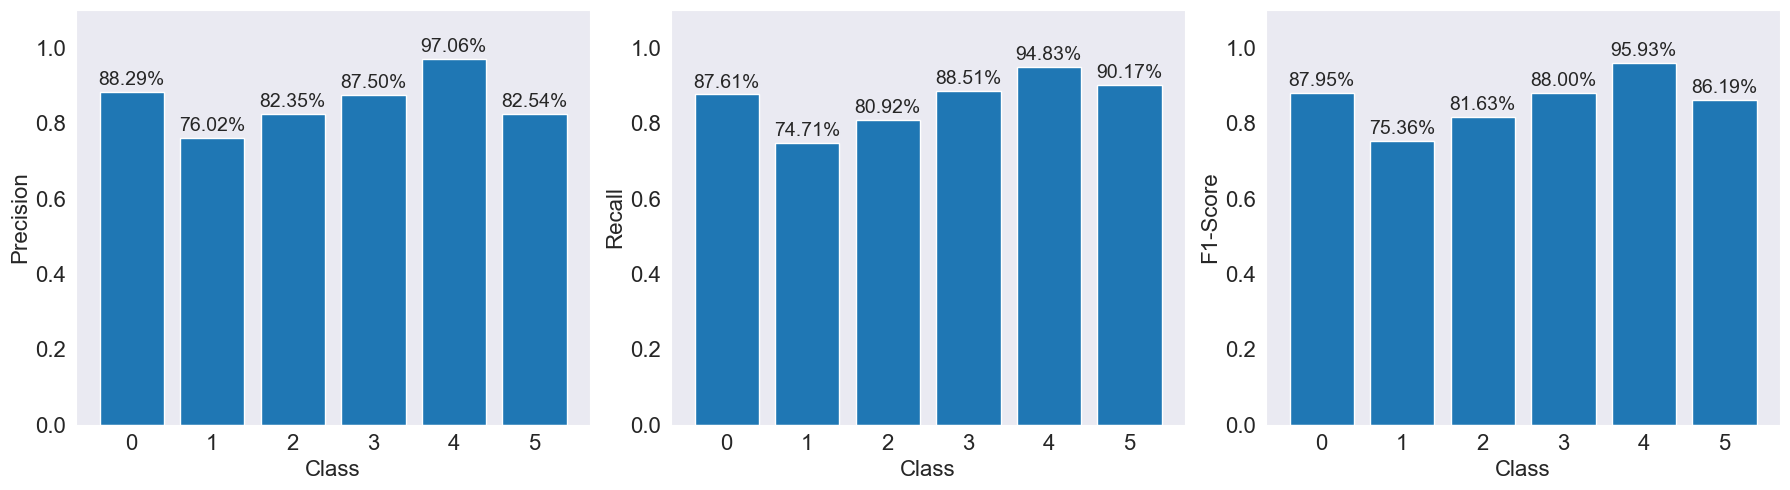

In [71]:
# Visualize the evaluation metrics

# Dictionary to store metrics for each class
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Dictionary to store average metrics across all classes
metrics_avg = {
    'Average Precision': precision_avg,
    'Average Recall': recall_avg,
    'Average F1-Score': f1_avg
}

# Create bar charts for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (metric_name, metric_values) in zip(axes, metrics.items()):
    # Plot bars for the metric values
    bars = ax.bar(range(len(metric_values)), metric_values)
    ax.set_xlabel('Class', fontsize=16)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.set_xticks(range(len(metric_values)))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylim(0.0, 1.1)  # Set y-axis limits for percentage display
    ax.grid(False)

    # Annotate bars with percentage values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',  # Display height as a percentage
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=14)

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  # Display the plot


In [87]:
def create_windows(data, window_size, step_size):
    """
    Create sliding windows from the data and their corresponding frame indices.

    Args:
    data (np.ndarray): The input data array.
    window_size (int): The number of time steps per window.
    step_size (int): The step size for sliding windows.

    Returns:
    tuple: A tuple containing:
        - windows (np.ndarray): An array of sliding windows.
        - indices (list): A list of indices corresponding to the end of each window.
    """
    windows = []
    indices = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
        indices.append(end - 1)  # The last index of the window
    return np.array(windows), indices



In [94]:
# Load the pre-trained Keras model
model = keras.models.load_model(model_filepath)

# Load the CSV file
csv_path = 'Frames/1_Petzold Luca_lq/feature_extraction.csv'  # Path to the CSV file
data = pd.read_csv(csv_path)

# Assume the last column is not needed for prediction
X = data.iloc[:, :-1].values  # Convert to a NumPy array

# Normalize position columns
normalized_X = normalize_positions(X)

# Sliding Windows Creation
window_size = 6  # Number of time steps per window
step_size = 1    # Step size for the sliding window
windows, indices = create_windows(normalized_X, window_size, step_size)

# Make predictions for each window
predictions = model.predict(windows)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Create an array to hold the frame predictions
frame_predictions = np.zeros(len(X), dtype=int)

# Assign predictions to the last frame of each window
for idx, pred_class in zip(indices, predicted_classes):
    frame_predictions[idx] = pred_class

# Handle initial and trailing frames
frame_predictions[:indices[0]] = predicted_classes[0]
frame_predictions[indices[-1] + 1:] = predicted_classes[-1]

# Create a DataFrame for the predicted classes
df_predictions = pd.DataFrame(frame_predictions, columns=['Predicted Class'])

# Create an array to hold the confidence scores for each frame
true_predictions = np.zeros((len(normalized_X), predictions.shape[1]))

# Assign confidence scores to the last frame of each window
for idx, prediction in zip(indices, predictions):
    true_predictions[idx] = prediction

# Handle the first few frames (fill with the first prediction)
true_predictions[:indices[0]] = predictions[0]
# Handle the last few frames (fill with the last prediction)
true_predictions[indices[-1] + 1:] = predictions[-1]

binary_predictions = np.zeros((len(X), predictions.shape[1]))
for i, pred_class in enumerate(frame_predictions):
    binary_predictions[i, pred_class] = 1

time_steps = np.arange(len(X)) 


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


In [95]:
# Check the distribution of predicted classes
unique, counts = np.unique(frame_predictions, return_counts=True)
print("Class distribution in predictions:", dict(zip(unique, counts)))

# Check the distribution of predicted classes (confidence scores)
unique, counts = np.unique(np.argmax(true_predictions, axis=1), return_counts=True)
print("Class distribution in predictions (confidence):", dict(zip(unique, counts)))

# Create a DataFrame for the predicted classes with confidence scores
df_predictions_confidence = pd.DataFrame(true_predictions, columns=[f'Class {i} Confidence' for i in range(predictions.shape[1])])

# Labels
y = data.iloc[:, -1].values

# Find indices where labels are not zero
non_zero_label_indices = np.where(y != 0)[0]

# Print the data for the non-zero labels
print(df_predictions_confidence.iloc[non_zero_label_indices])

Class distribution in predictions: {0: 73, 1: 3, 2: 7, 3: 9, 4: 11, 5: 8}
Class distribution in predictions (confidence): {0: 73, 1: 3, 2: 7, 3: 9, 4: 11, 5: 8}
    Class 0 Confidence  Class 1 Confidence  Class 2 Confidence  \
43            0.453314        5.457630e-01        9.219398e-04   
46            0.042755        7.853491e-05        9.571540e-01   
52            0.000885        2.456894e-10        2.872951e-08   
61            0.009610        6.491091e-06        8.126026e-07   
68            0.006280        1.307965e-07        5.006151e-09   

    Class 3 Confidence  Class 4 Confidence  Class 5 Confidence  
43        2.114140e-07        5.285152e-07        7.378166e-07  
46        1.109854e-05        6.083252e-07        3.104915e-07  
52        9.991154e-01        5.370834e-10        1.331690e-08  
61        7.926380e-04        9.895257e-01        6.433122e-05  
68        7.334765e-09        9.668231e-06        9.937103e-01  


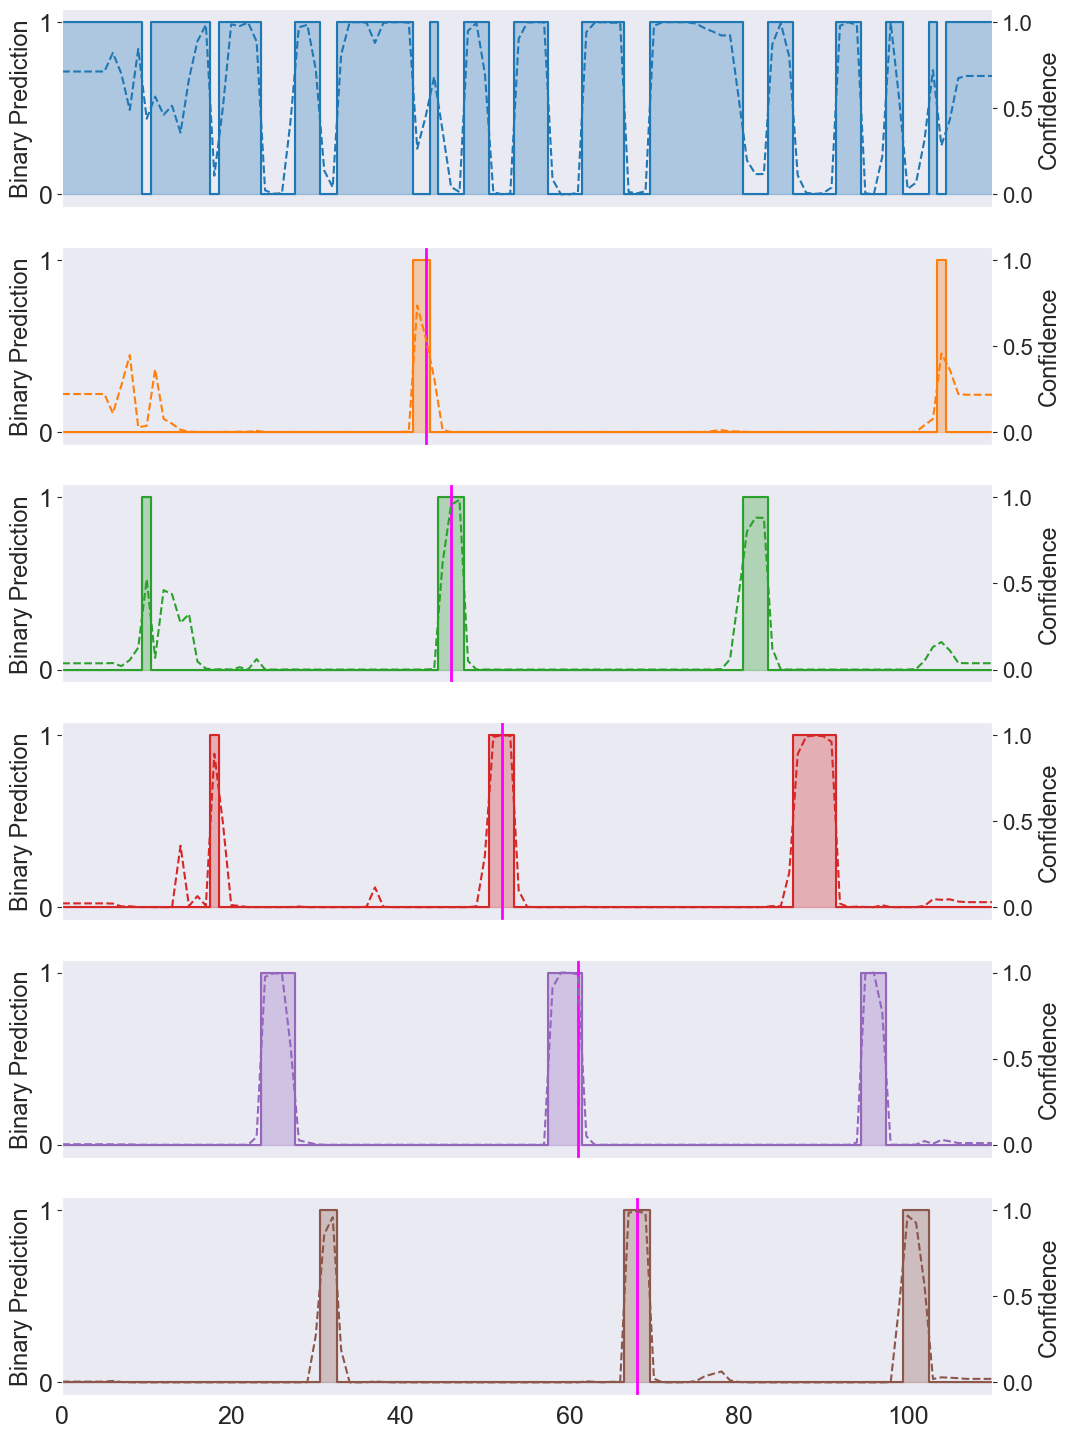

In [98]:
# Define a color map for different classes
colors = plt.colormaps['tab10']

num_classes = predictions.shape[1]
fig, axes = plt.subplots(num_classes, 1, figsize=(12, 3 * num_classes), sharex=True)

for class_idx in range(num_classes):
    ax = axes[class_idx]
    ax.step(time_steps, binary_predictions[:, class_idx], label=f'Class {class_idx} Detection', color=colors(class_idx), where='mid')
    ax.fill_between(time_steps, binary_predictions[:, class_idx], step='mid', color=colors(class_idx), alpha=0.3)
    ax.set_ylabel('Binary Prediction', fontsize=17)
    ax.set_ylim(-0.075, 1.075)  # Y-Axis limit slightly below 0 and above 1 for better visibility
    ax.set_yticks([0, 1])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlim(time_steps[0], time_steps[-1])  # Set x-axis limits to the range of time steps
    ax.grid(False)
    
    # Enhancements for the vertical line marking
    if class_idx > 0:
        label_index = non_zero_label_indices[class_idx - 1]
        if label_index.size > 0:
            # Improved visibility of the vertical line
            ax.axvline(x=label_index, color='magenta', linestyle='-', linewidth=2, label=f'Actual Label ({label_index})')

    # Create a twin y-axis to plot confidence levels
    ax2 = ax.twinx()
    ax2.plot(time_steps, true_predictions[:, class_idx], label=f'Class {class_idx} Confidence', color=colors(class_idx), linestyle='--')
    ax2.set_ylabel('Confidence', fontsize=17)
    ax2.set_ylim(-0.075, 1.075)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.grid(False)